<a href="https://colab.research.google.com/github/otoperalias/miscellanea/blob/main/TrackingBabyWeight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tracking your baby weight

### Some brief instructions:

* This notebook allows to track your baby's weight by adding weight observations to a table stored in Google Sheets and representing the baby weight evolution along with the WHO standard growth percentiles. 
* This notebook contains Python code but you do not need to actually know Python to implement it. You just need to execute the following cell and provide the data asked by the emerging messages.
* Before executing the following cell for the first time, you need to create a table in Google Sheets with the following format:
<br><br>     
<img src="https://github.com/otoperalias/miscellanea/raw/main/images/BabyWeightTable.jpg" alt="drawing" width="450"/>

  where:  
  * **date** is a column starting the day of birth, then filling it by dragging downward. Date format must be YEAR-MONTH-DAY (XXXX-XX-XX).
  * **age_days** starts with a 0 and it is also necessary to fill by dragging downward.
  * **weight** is the name of the column which will contain the weight observations. It is only needed to write the name of the column.

* Finally, you also first need to indicate the sex and (optionally) the name of your baby at the begining of next cell.

### Code: Execute this cell by clicking on the ▶ symbol on the top-left corner.

Do you want to update the table? Y/N: Y
Data referred to today?: Y/N Y
Weight (decimals with dot): 5.45
Want to update again the table? Y/N: N


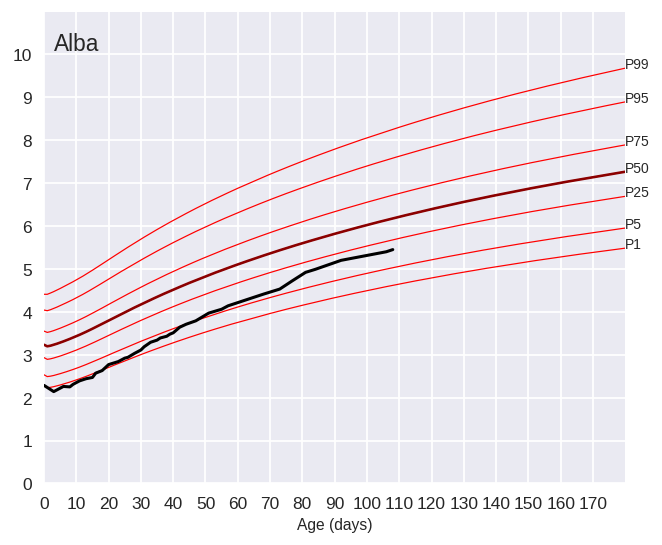

In [23]:
# Define sex and name
sex="female" # Sex must be "male" or "female"
babyname="Alba"

# Imports (general)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
today=pd.to_datetime("today").strftime('%Y-%m-%d')

# Get permission to google drive
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

# Read table in Google Sheets
worksheet = gc.open("BabyWeight").sheet1 

# Convert to a DataFrame
rows = worksheet.get_all_values()
df=pd.DataFrame.from_records(rows)
df.drop([0],inplace=True)
df.rename(columns={0:"date",1:"age_days",2:"weight"},inplace=True)
df=df.set_index("date")
df.index = pd.to_datetime(df.index)

# Update dataframe and save
update=input("Do you want to update the table? Y/N: ")  # 1. Indicate if you want to update the table
if update=="Y":
  while update=="Y":
    istoday=input("Data referred to today?: Y/N ")  # 3. Indicate if the weight observation refer to today
    if istoday=="Y":
      date=today  # If date is today, the date value is automatically provided
    else:
      date=input("Date: XXXX-XX-XX (Year/Month/Day): ")
    weight=input("Weight (decimals with dot): ")
    df.loc[date,"weight"]=weight
    update=input("Want to update again the table? Y/N: ")
  # Save
  import gspread_dataframe as gd
  gd.set_with_dataframe(worksheet, df.reset_index())

# Some data processing
df["w"]=df["weight"]
df["w"]=pd.to_numeric(df["w"],errors='coerce')
df["age_days"]=pd.to_numeric(df["age_days"],errors='coerce')

# Linear interpolation
df_nona_w = df.dropna(subset = ['w'])
f = interp1d(df_nona_w['age_days'], df_nona_w['w'])
fechamax_w=df["w"][pd.notnull(df.w)].idxmax()
df.loc[:fechamax_w,"w"] = f(df.loc[:fechamax_w,'age_days'])
  # Set Age as index
df=df.set_index("age_days")

# Growth standards (https://www.who.int/tools/child-growth-standards/standards/weight-for-age)
if sex=="male":
  growth_st=pd.read_csv("https://raw.githubusercontent.com/otoperalias/miscellanea/main/data/wfa_boys_p_exp.csv",sep=";", index_col=0)
elif sex=="female":
  growth_st=pd.read_csv("https://raw.githubusercontent.com/otoperalias/miscellanea/main/data/wfa_girls_p_exp.csv",sep=";", index_col=0)

  # PLOT
plt.style.use('seaborn')
fig,ax=plt.subplots(figsize=(6,5), dpi=125)
growth_st[["P1","P5","P25","P50","P75","P95","P99"]].plot(ax=ax, color="red",lw=0.7)
growth_st["P50"].plot(ax=ax, color="darkred",lw=1.5)
df["w"].plot(ax=ax,color="black")
ax.get_legend().remove()
ax.set_xlim(1,180)
ax.set_ylim(1,11) 
ax.text(3,10.1,babyname,size=13)
ax.set_xlabel("Age (days)",size=9)
ax.set_xticks(np.arange(0, 180, 10))
ax.set_yticks(np.arange(0, 11, 1))
for p in ["P1","P5","P25","P50","P75","P95","P99"]:
  ax.text(180,growth_st[p].iloc[180],p,size=8)
plt.show()